In [28]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('../../')

In [29]:
import yaml
from pathlib import Path
from typing import Union
from functools import reduce

def save_yaml_from_csvs(directory_path: Union[str, Path], replace_in_filename: dict[str, str] = None) -> Path:
    directory = Path(directory_path)
    yaml_data = []
    
    for file in directory.glob('*.xlsx'):
        df = pd.read_excel(file)
        entry = {
            'file': reduce(lambda fn, kv: fn.replace(*kv), replace_in_filename.items(), file.name),
            'timestamp_missed_fish': [],
            'fish_track_IDs': df[df['classification'] == 'fish']['id'].tolist(),
        }
        yaml_data.append(entry)
    
    yaml_file_path = directory / "fish_labels.yaml"
    
    with open(yaml_file_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)
    
    return yaml_file_path

directory_path = "../../data/labels/Passe3/"
output_yaml_path = save_yaml_from_csvs(directory_path, replace_in_filename={"_YP_completed": "", ".xlsx": ".csv"})
print(f"YAML file saved at: {output_yaml_path}")


YAML file saved at: ../../data/labels/Passe3/fish_labels.yaml


In [30]:
%load_ext autoreload
%autoreload 2
from analysis.classification_utils.features import FeatureGenerator, TrackClassifier, TrackPlotter


gt_fish_id_yaml = "../../data/labels/Passe3/fish_labels.yaml"

gen = FeatureGenerator(
    gt_fish_id_yaml=gt_fish_id_yaml,
    measurements_csv_dir="../../data/model_output/",
    min_track_length=20, 
    force_feature_recalc=True,
    force_test_feature_recalc=True,
    min_overlapping_ratio=0.5,
    load_old_measurements=False,
    load_old_test_files=False,
    rake_mask_path="../demo/masks/stroppel_rake_front_mask.png",
    flow_area_mask_path="../demo/masks/sonar_controls.png",
    trajectory_min_overlap_ratio=0.15,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculating/reading features


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Calculating/reading features


0it [00:00, ?it/s]


In [31]:
gen.calc_feature_dfs()
mmts_dfs = gen.measurements_dfs.copy()

/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Calculating features for train data


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWar

# Get an Idea of Trajectory and Ground Truth

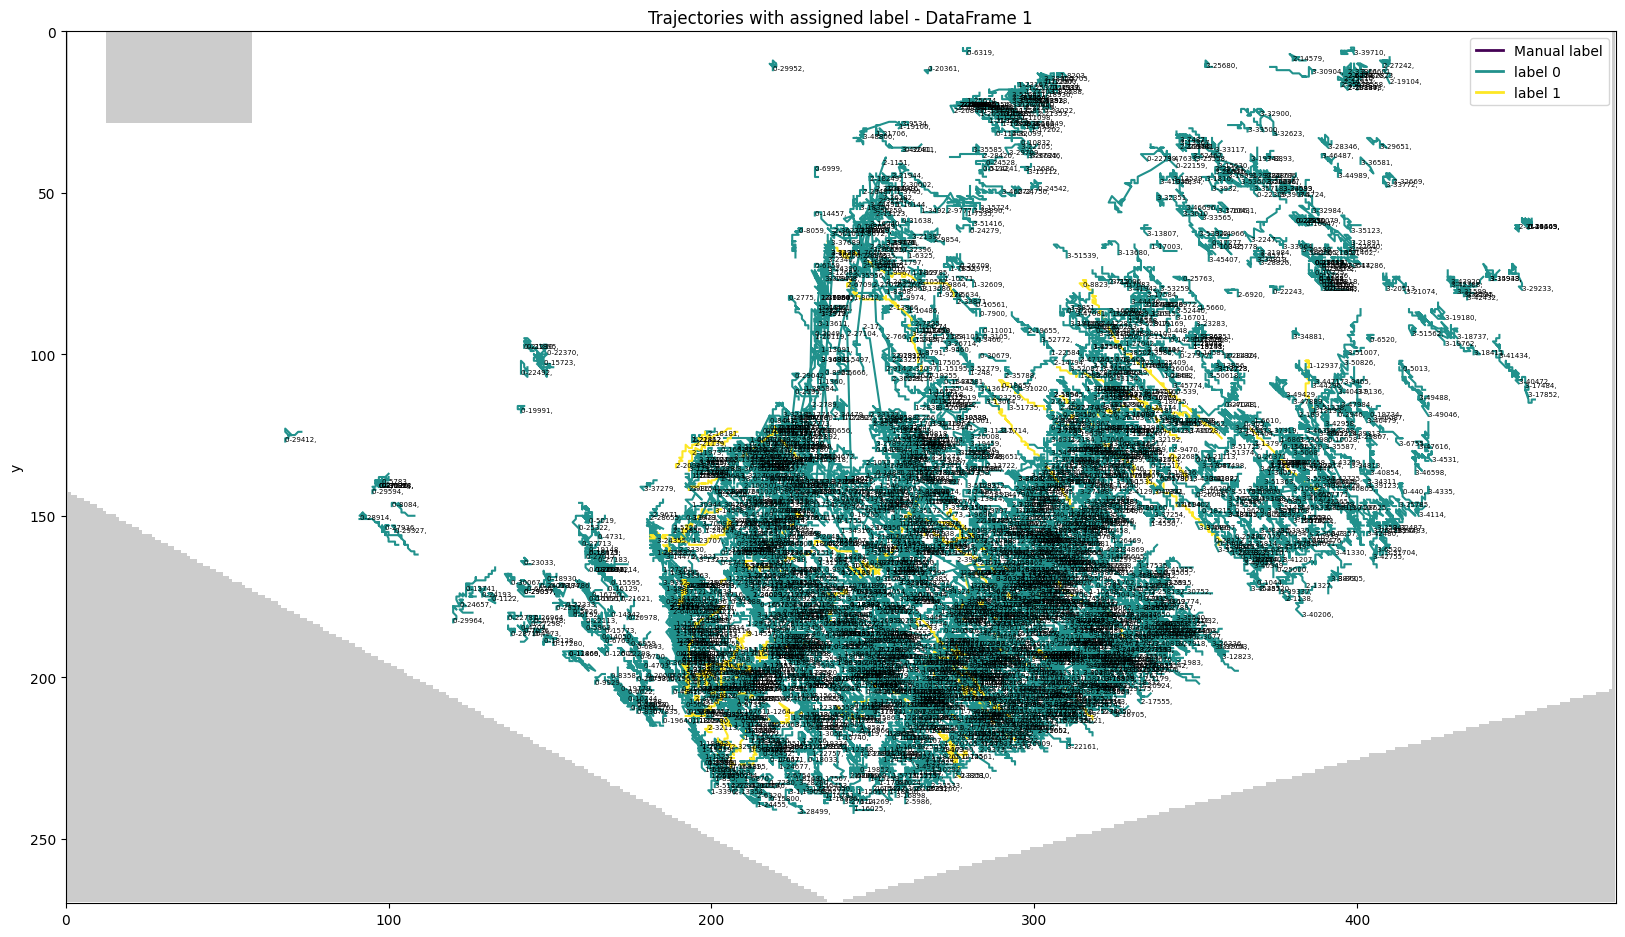

In [32]:
from analysis.classification_utils.features import TrackPlotter

plotter = TrackPlotter(mmts_dfs, gen.masks)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
    figsize=(20, 20),
)

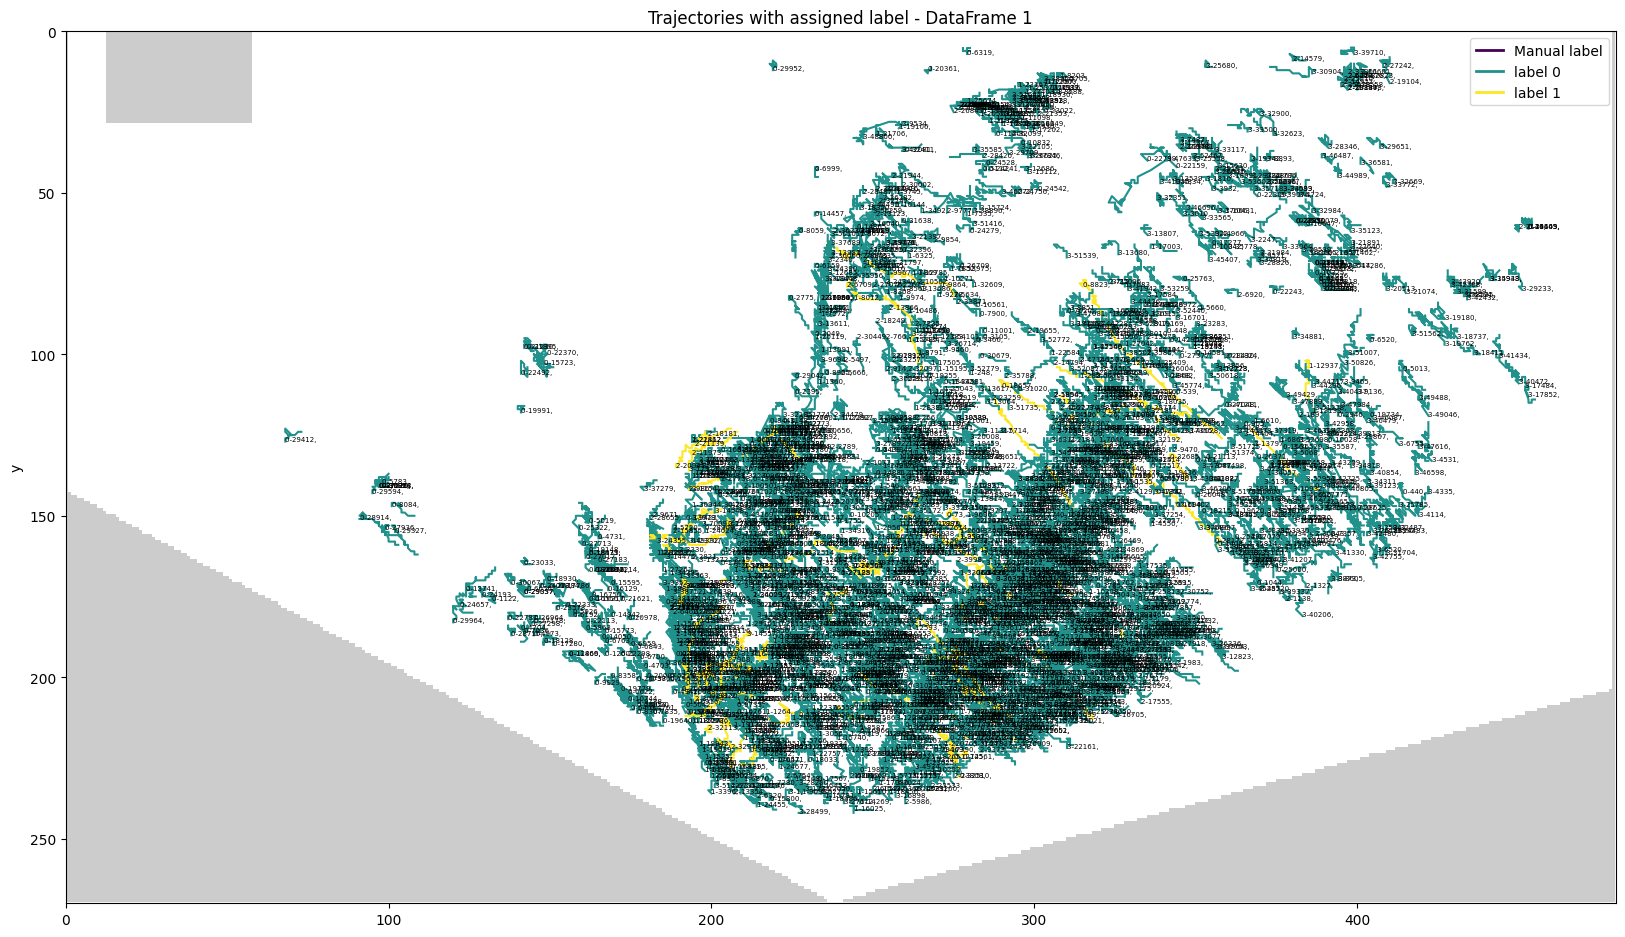

In [40]:
import pandas as pd
import numpy as np

def remove_jumps(df: pd.DataFrame, threshold: int = 10):
    df = df.copy(deep=True)
    
    def process_group(group):
        # Calculate the Euclidean distance between consecutive points within the group
        group['dist'] = np.sqrt(group['x'].diff()**2 + group['y'].diff()**2)
        
        # Find the indices where the distance is greater than the threshold
        jump_indices = group.index[group['dist'] > threshold].tolist()
        
        # Add the start and end indices of the group
        jump_indices = [group.index[0]] + jump_indices + [group.index[-1]]
        
        # Split the group into segments at the jump indices
        segments = []
        for idx in range(len(jump_indices)-1):
            prior_idx = int(idx != len(jump_indices)-2)
            segments.append(group.loc[jump_indices[idx]:(jump_indices[idx+1]-prior_idx)])
            
        # Find the longest segment
        longest_segment = max(segments, key=len)
        
        return longest_segment
    
    # Apply the process_group function to each group
    df = df.groupby('id').apply(process_group).reset_index(drop=True)
    
    return df

# Apply the function to each DataFrame in mmts_dfs
mmts_dfs = [remove_jumps(df) for df in mmts_dfs]

plotter = TrackPlotter(mmts_dfs, gen.masks)
plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
    figsize=(20, 20),
)

# Identify River Velocity from Floating Debris Cluster

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

def calculate_velocities(mmts_dfs):
    velocities = []

    for df in mmts_dfs:
        unique_ids = df['id'].unique()
        for uid in unique_ids:
            sample = df[df.id == uid]
            if len(sample) > 1:  # Ensure there are at least two points to calculate velocity
                dx = sample.x.iloc[-1] - sample.x.iloc[0]
                dy = sample.y.iloc[-1] - sample.y.iloc[0]
                dt = sample.frame.iloc[-1] - sample.frame.iloc[0]
                vx = dx / dt
                vy = dy / dt
                gt_label = sample.gt_label.iloc[0]  # Assuming gt_label is the same for all points of the same id
                velocities.append((uid, vx, vy, gt_label))
    
    return pd.DataFrame(velocities, columns=['id', 'vx', 'vy', 'gt_label'])

# Assuming mmts_dfs is already defined
velocities_df = calculate_velocities(mmts_dfs)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)  # You can change the number of clusters
velocities_df['cluster'] = kmeans.fit_predict(velocities_df[['vx', 'vy']])

# Plotting clustered velocities
plt.figure(figsize=(10, 6))
scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Velocity Components (vx vs vy)')
plt.xlabel('vx')
plt.ylabel('vy')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# Get cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

# Plotting velocities colored by gt_label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['gt_label'], cmap='viridis', alpha=0.5)
plt.title('Velocity Components (vx vs vy) Colored by gt_label')
plt.xlabel('vx')
plt.ylabel('vy')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="gt_label")
plt.show()

# Clean Trajectory Data

In [43]:
feature_df = pd.concat(mmts_dfs).groupby('id').first().select_dtypes(include=[np.number])
feature_df.drop(
    columns=[
        'x_avg',
        'y_avg',
        'video_id',
    ], 
    inplace=True
)
feature_df.reset_index(inplace=True)

# Check for NaN values in the DataFrame
nan_values = feature_df.isna()
nan_counts = feature_df.isna().sum()

# Print the columns that have NaN values
print(nan_counts)

# drop rows with NaN values
feature_df = feature_df.dropna()

id                                                 0
frame                                              0
x                                                  0
y                                                  0
w                                                  0
h                                                  0
v_x                                                0
v_y                                                0
contour_area                                       0
stddev_of_intensity                                0
v_xr                                               0
v_yr                                               0
tile_blob_counts                                   0
x_displacement                                     0
y_displacement                                     0
v_x_smoothed_avg                                  10
v_y_smoothed_avg                                  10
v_smoothed_avg                                    10
v_smoothed_std                                

# Find the Best Model and Features

In [157]:
from analysis.classification_utils.classifier_evaluation import RandomClassifier, ProbaClassifier, greedy_feature_selection, train_and_evaluate_model, classifier_selection
        

random_state = 3
imbalance = feature_df['gt_label'].value_counts()[0] / sum(feature_df['gt_label'].value_counts())
# classifiers = {
#     'gradient_boosting': GradientBoostingClassifier(random_state=random_state),
#     'random_forest': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
#     'xgboost': XGBClassifier(random_state=random_state, scale_pos_weight=imbalance),  # Adjust scale_pos_weight based on imbalance ratio
#     'logistic_regression': LogisticRegression(random_state=random_state, class_weight='balanced'),
#     'svm': SVC(random_state=random_state, class_weight='balanced'),
#     'adaboost': AdaBoostClassifier(random_state=random_state),
#     'knn': KNeighborsClassifier(),
#     'random_benchmark': RandomClassifier(feature_df['gt_label'].value_counts().to_dict()),
# }
# classifiers['vote_best_3'] = VotingClassifier(
#     estimators=[
#         ('gradient_boosting', classifiers['gradient_boosting']),
#         ('xgboost', classifiers['xgboost']),
#         ('random_forest', classifiers['random_forest']),
#     ],
#     voting='hard',
# )
classifiers = {
    'proba_gradient_boosting': ProbaClassifier(GradientBoostingClassifier, proba_threshold=0.2),
    'proba_xgboost': ProbaClassifier(XGBClassifier, base_estimator_kwargs={"scale_pos_weight": imbalance}, proba_threshold=0.1),
    'proba_logistic_regression': ProbaClassifier(LogisticRegression, base_estimator_kwargs={"class_weight": "balanced"}, proba_threshold=0.6),
    'proba_svm': ProbaClassifier(SVC, base_estimator_kwargs={"class_weight": "balanced", "probability": True}, proba_threshold=0.2),
}

### Find the Best Feature Selection with a Greedy Algorithm

In [139]:
features_to_explore = [
    'contour_area',
    'stddev_of_intensity',
    'v_smoothed_avg', 'v_smoothed_std', 'v_50th_percentile',
    'v_90th_percentile', 'v_95th_percentile',
    'traversed_distance',
    'average_smoothed_curvature_15',
    'median_smoothed_curvature_15',
    'average_bbox_size', 'average_distance_from_start',
    'average_contour_area',
    'average_pixel_intensity',
    'average_distance_from_start/traversed_distance',
]

# current best: ['traversed_distance', 'v_95th_percentile', 'average_pixel_intensity', 'average_distance_from_start', 'v_smoothed_avg']
target_metric = 'F2_score'
optim_features, optim_metric = greedy_feature_selection(
    feature_df, 
    classifiers['proba_logistic_regression'], 
    all_features=features_to_explore,
    performance_metric=target_metric,
    max_features=6,
    force_features=['traversed_distance'],
)
print(f"Selected features: {optim_features}")
print(f"Performance metric ({target_metric}): {optim_metric}")

F2_score: 0.13317191283292978
F2_score: 0.26666666666666666
F2_score: 0.17671517671517672
F2_score: 0.11876484560570073
F2_score: 0.10158013544018057
F2_score: 0.12048192771084337
F2_score: 0.18085106382978727
F2_score: 0.2156862745098039
F2_score: 0.25616698292220114
F2_score: 0.12285012285012285
F2_score: 0.1848249027237354
F2_score: 0.14976958525345624
F2_score: 0.15151515151515152
F2_score: 0.12048192771084337
Current best score: 0.26666666666666666 with features: ['traversed_distance', 'average_distance_from_start']
F2_score: 0.37362637362637363
F2_score: 0.2923387096774194
F2_score: 0.25727069351230425
F2_score: 0.29816513761467894
F2_score: 0.25316455696202533
F2_score: 0.28066528066528074
F2_score: 0.2824267782426778
F2_score: 0.24654832347140035
F2_score: 0.3546910755148742
F2_score: 0.2777777777777778
F2_score: 0.3174603174603175
F2_score: 0.4048140043763676
F2_score: 0.25316455696202533
Current best score: 0.4048140043763676 with features: ['traversed_distance', 'average_dis

### Compare Different Models with the Features

In [ ]:
optim_features = ['traversed_distance', 'average_distance_from_start', 'v_smoothed_std', 'average_pixel_intensity', 'stddev_of_intensity', 'v_95th_percentile']
best_classifier, _ = classifier_selection(
    feature_df, 
    classifiers, 
    features=optim_features,
    target_metric="F2_score",
)

### Exact Performance of Best Model and Features

In [162]:
metrics, y_pred, trained_classifier = train_and_evaluate_model(
    feature_df,
    classifier=classifiers['proba_logistic_regression'],
    metrics_to_show=['Accuracy', 'Precision', 'Recall', 'F1_score', 'F2_score', 'F3_score', 'F5_score', 'F10_score'],
    features=optim_features,
)

Accuracy: 0.8956204379562044
Precision: 0.15335463258785942
Recall: 0.6956521739130435
F1_score: 0.2513089005235602
F2_score: 0.4074702886247878
F3_score: 0.5139186295503213
F5_score: 0.6123650637880275
F10_score: 0.672119783723832


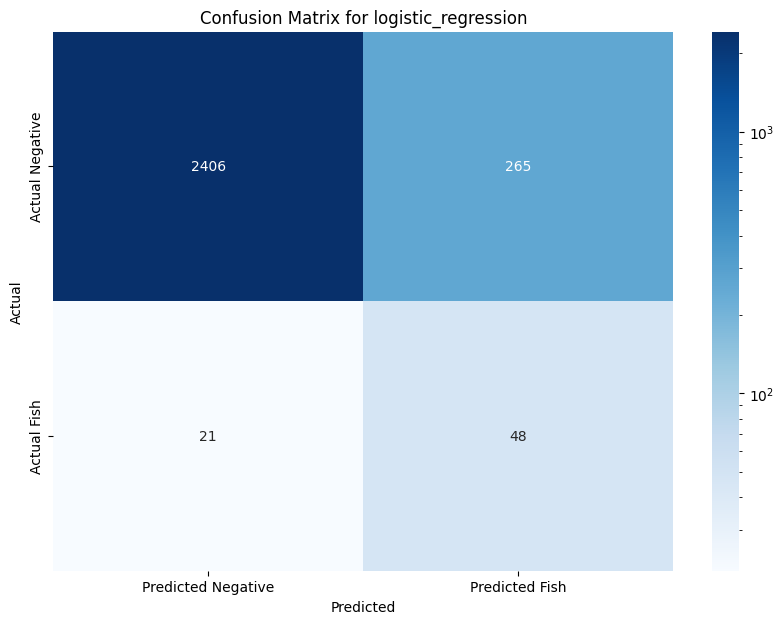

In [163]:
from analysis.classification_utils.metrics import plot_confusion_matrix


y = feature_df['gt_label']
plot_confusion_matrix(y, y_pred, 'logistic_regression')

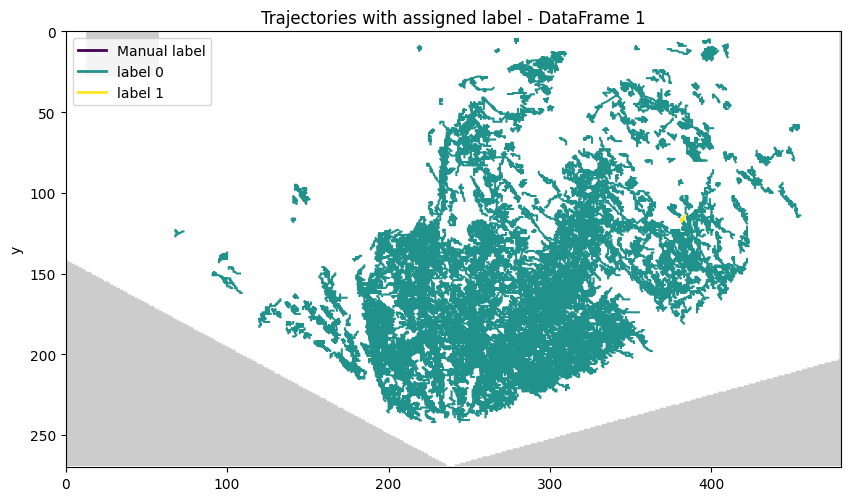

ground truth labels


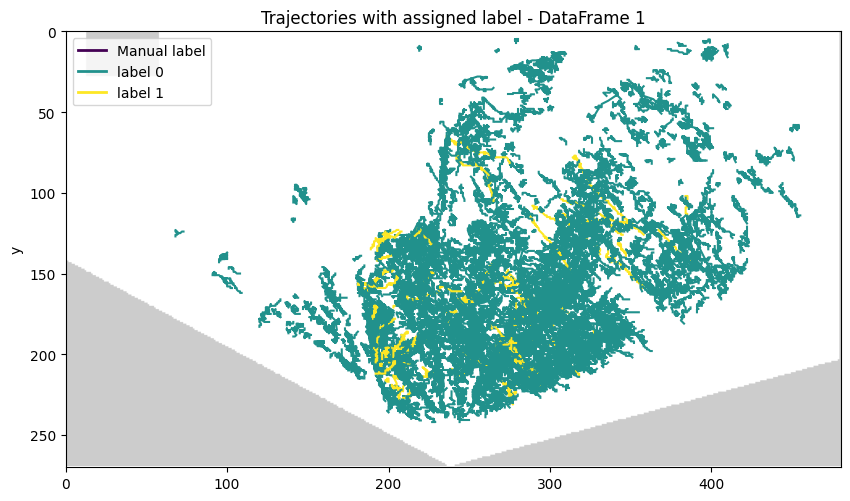

In [53]:
plotter.overwrite_classification_v2(pd.DataFrame(y_pred, columns=['xgboost'], index=feature_df.index))

plotter.plot_track_pairings(
    show_track_id=False,
    mask_to_show="flow_area_mask",
    column_with_label="xgboost",
)

print("ground truth labels")
plotter.plot_track_pairings(
    show_track_id=False,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

In [48]:
dump_df = plotter.measurements_dfs[0].copy().drop(columns=['image_tile', 'binary_image'])
dump_df['classification_v2'] = dump_df['xgboost'].astype(int)
dump_df.to_csv('../../data/model_output/Passe3_Mar11_12-37-58_classification_v2.csv', index=False)


# Correlation Matrix to Identify Important Features

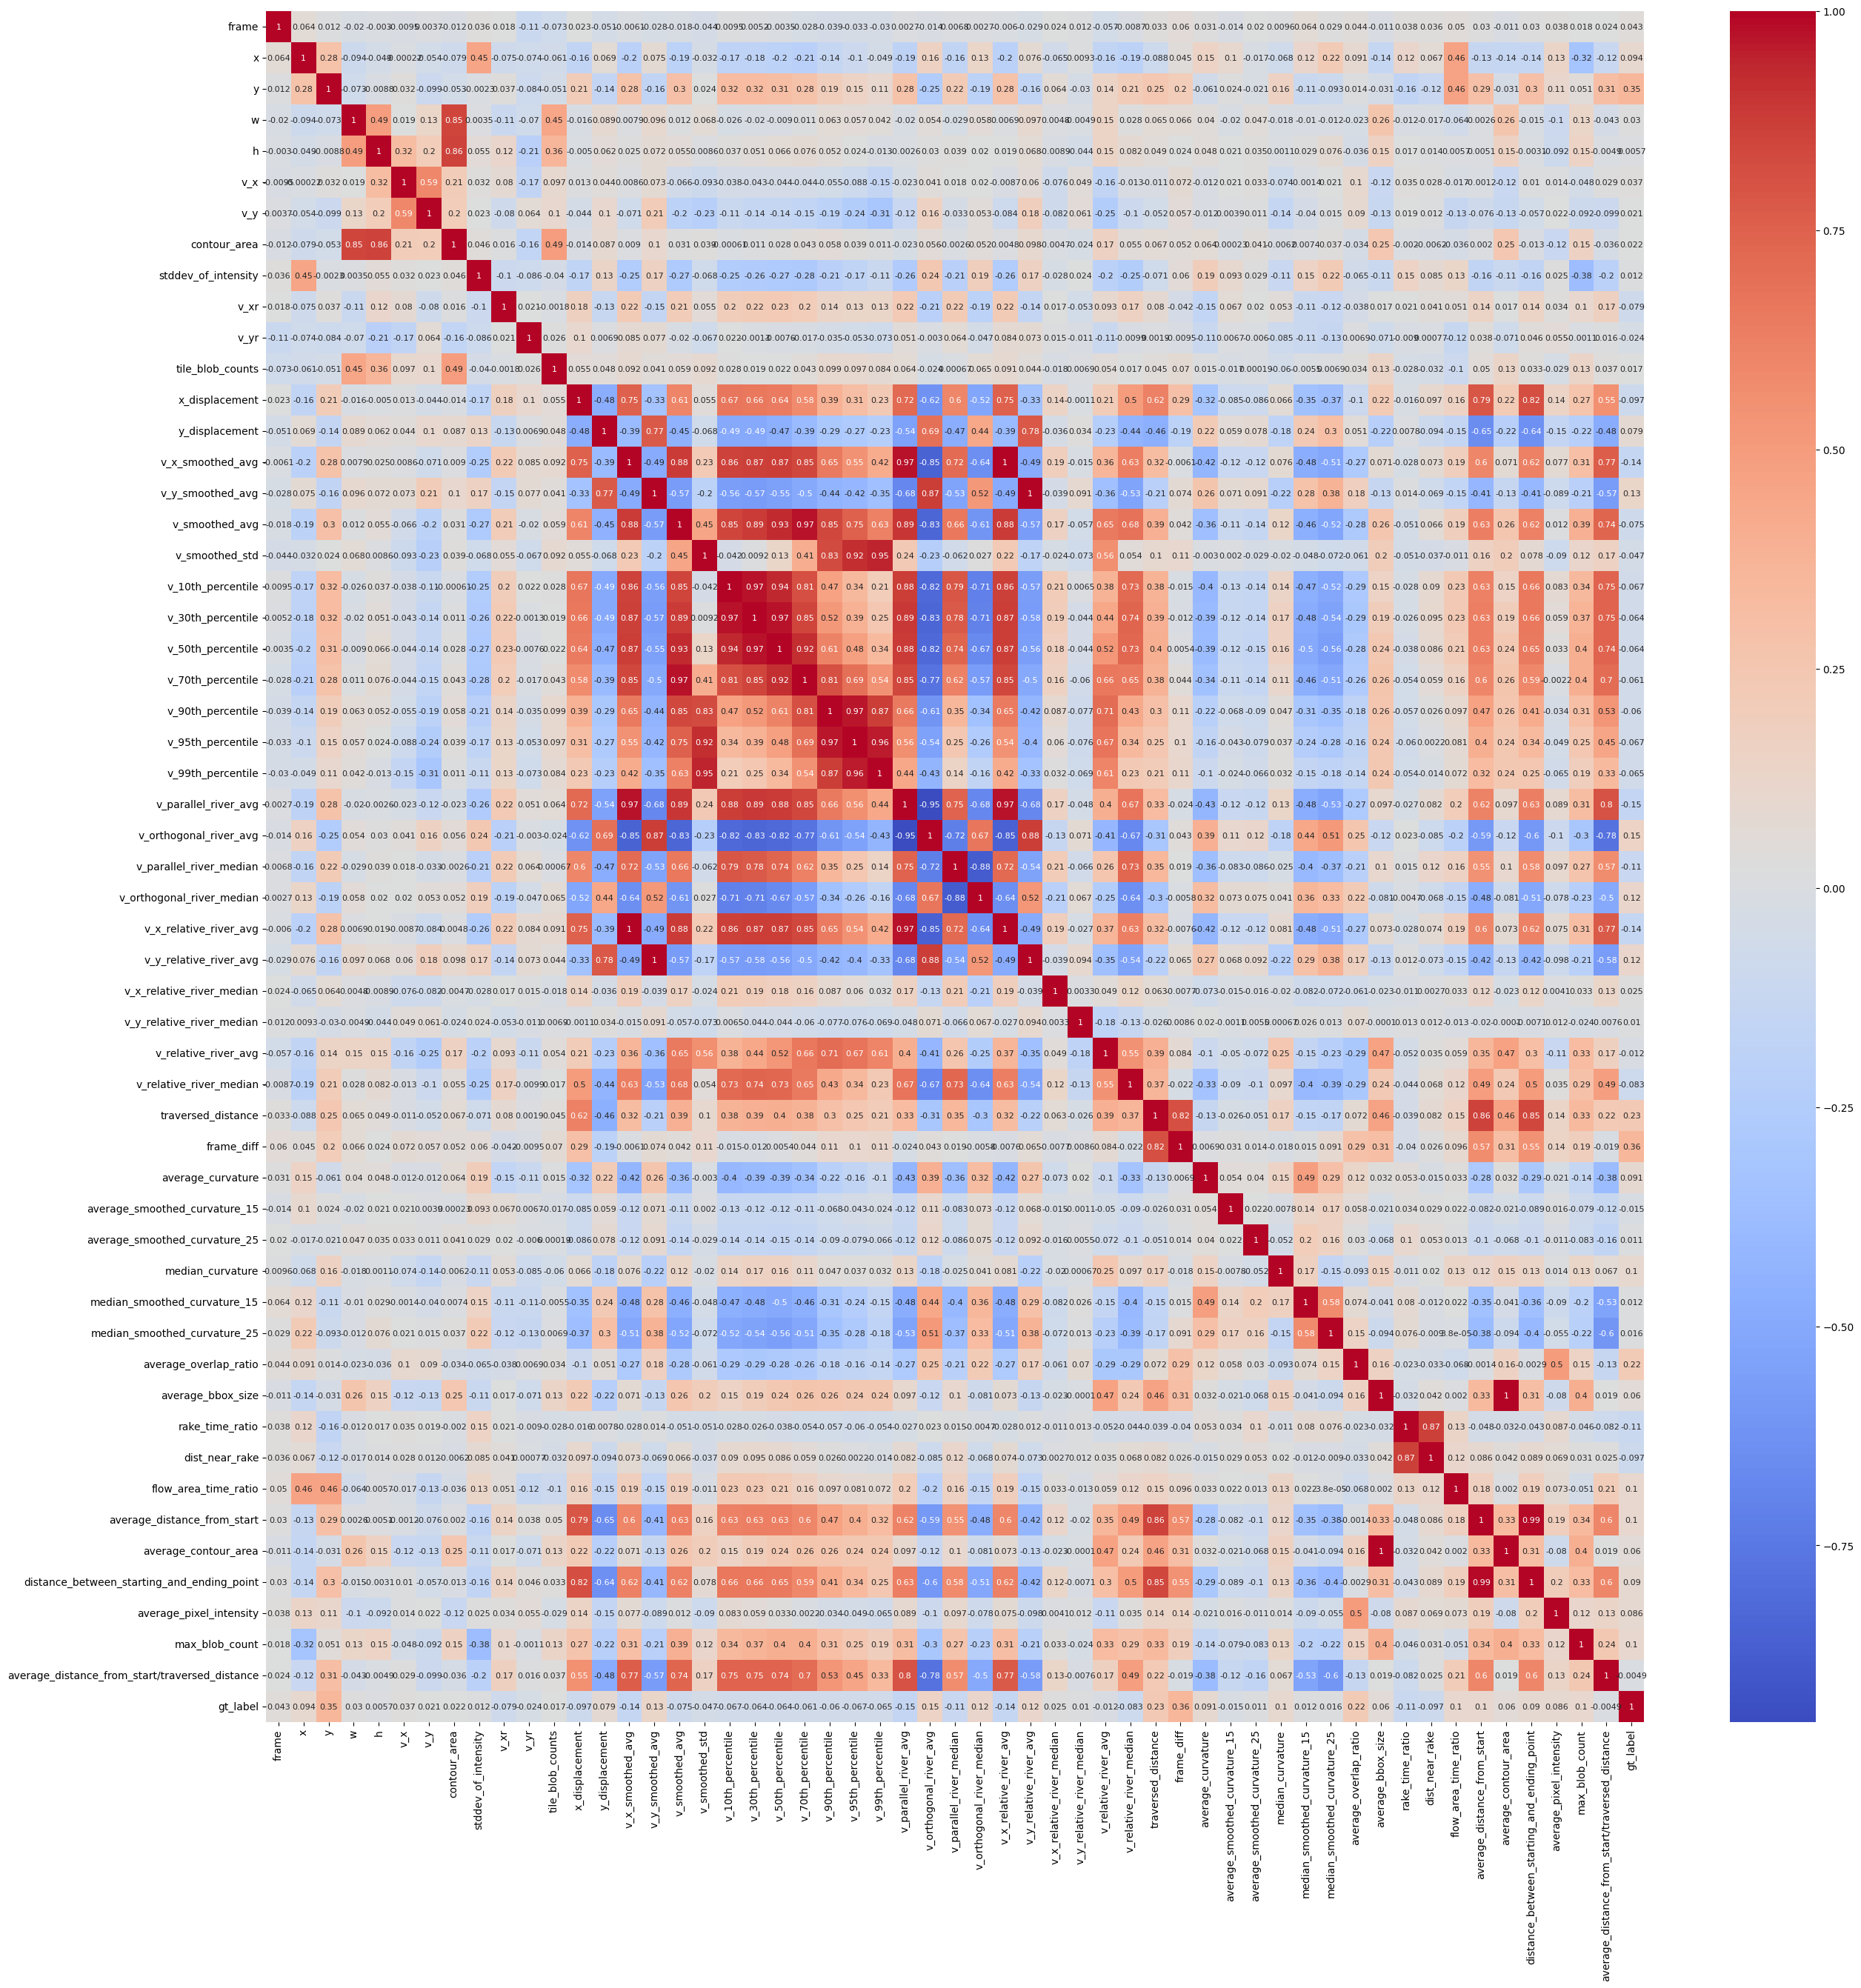

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 30))

# Compute the correlation matrix
corr_matrix = feature_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":8})

# Show the plot
plt.show()

# Shorten a Video

In [ ]:
import cv2

def cut_video(input_path, start_time, end_time):
    # Read the video
    video = cv2.VideoCapture(input_path)

    # Get the frame rate of the video
    fps = video.get(cv2.CAP_PROP_FPS)

    # Convert start and end time to seconds
    start_seconds = int(start_time.split(':')[0]) * 60 + int(start_time.split(':')[1])
    end_seconds = int(end_time.split(':')[0]) * 60 + int(end_time.split(':')[1])

    # Calculate the start and end frames
    start_frame = int(start_seconds * fps)
    end_frame = int(end_seconds * fps)

    # Set the video writer
    output_path = input_path.replace('.mp4', '_short.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (int(video.get(3)), int(video.get(4))))

    # Read and write frames within the specified time frame
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break

        if frame_count >= start_frame and frame_count <= end_frame:
            output_video.write(frame)

        frame_count += 1

        if frame_count > end_frame:
            break

    # Release the video capture and writer
    video.release()
    output_video.release()

    print(f"Video saved as {output_path}")

# Example usage
input_path = "../../data/model_output_classified/Passe3_Mar11_12-37-58_classified.mp4"
start_time = "00:45"
end_time = "01:10"

cut_video(input_path, start_time, end_time)